# Lesson 4 Assignment - Automobile Price Hypothesis Testing
## Author - Tyler Crosse

### Instructions
Test hypotheses for the price of automobiles:

1. Compare and test the normality of the distributions of **price** and **log price**. <br/>
Use both a graphical method and a formal test. Hint: remember these relationships will always be approximate.

2. Test significance of **price (or log price)** stratified by 
a) **fuel type**, b) **aspiration**, and c) **rear vs. front wheel drive**. <br />Use both graphical methods and the formal test.

3. Apply ANOVA and Tukey's HSD test to the auto price data to compare the **price (or log price** if closer to a normal distribution) of autos stratified by **body style**.

4. Graphically explore the differences between the price conditioned by the categories of each variable. <br/>
Hint: Make sure you have enough data for each category and drop categories with insufficient data.

5. Use standard ANOVA and Tukey HSD to test the differences of these groups.


#### Note: 
Please clearly outline the results of these tests with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

## Load and set up the data

In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Cleaned up Dataset location
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"

# Read the .csv file with the pandas read_csv method
energy = pd.read_csv(fileName)

In [16]:
# clean up data

## Remove rows with missing values, accounting for mising values coded as '?'
cols = ['price', 'bore', 'stroke', 
      'horsepower', 'peak-rpm']
for column in cols:
    energy.loc[energy[column] == '?', column] = np.nan
    energy.dropna(axis = 0, inplace = True)

## Convert some columns to numeric values
for column in cols:
    energy[column] = pd.to_numeric(energy[column])

In [17]:
# add 'log price' to the df
energy['log-price'] = np.log(energy.price)

In [4]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 204
Data columns (total 27 columns):
symboling            195 non-null int64
normalized-losses    195 non-null object
make                 195 non-null object
fuel-type            195 non-null object
aspiration           195 non-null object
num-of-doors         195 non-null object
body-style           195 non-null object
drive-wheels         195 non-null object
engine-location      195 non-null object
wheel-base           195 non-null float64
length               195 non-null float64
width                195 non-null float64
height               195 non-null float64
curb-weight          195 non-null int64
engine-type          195 non-null object
num-of-cylinders     195 non-null object
engine-size          195 non-null int64
fuel-system          195 non-null object
bore                 195 non-null float64
stroke               195 non-null float64
compression-ratio    195 non-null float64
horsepower           195 non-n

## 1. Testing normality of price
Compare and test the normality of the distributions of price and log price. 
Use both a graphical method and a formal test. Hint: remember these relationships will always be approximate.

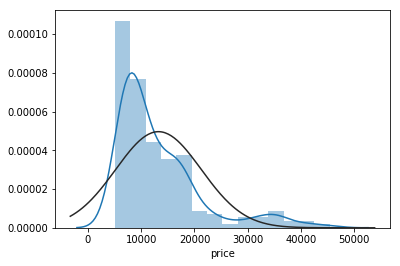

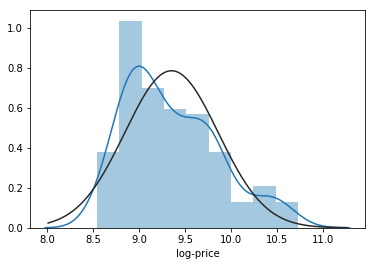

In [18]:
# graph the distributions
sns.distplot(energy['price'], fit=stats.norm)
plt.show()
sns.distplot(energy['log-price'], fit=stats.norm)
plt.show()

At first glance they look they have a positive skew. It also looks like price has a stronger positive skew than log-price. Which makes sense because taking the log of something is a method of normalization.

In [22]:
stats.normaltest(energy['price'])

NormaltestResult(statistic=74.01989343304248, pvalue=8.448592541649762e-17)

In [23]:
stats.normaltest(energy['log-price'])

NormaltestResult(statistic=13.632686978654453, pvalue=0.0010957201185796998)

### 1. Discussion
From the documentation on <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html"> scipy.stats.normaltest</a> the statistic is "s^2 + k^2, where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest." The pvalue is "a 2-sided chi squared probability for the hypothesis test." The pvalue of price was 8.4486 which is outside most acceptable ranges to accept the hypothesis and suggest that price is not normally distrubuted. The pvalue for log-price was 0.0011 which is likely low enough to accept the hypothesis that the data is normally distrubuted.

## 2. Testing significance of startified price
Test significance of price (or log price) stratified by a) fuel type, b) aspiration, and c) rear vs. front wheel drive. 
Use both graphical methods and the formal test.

(0.0, 50000.0)

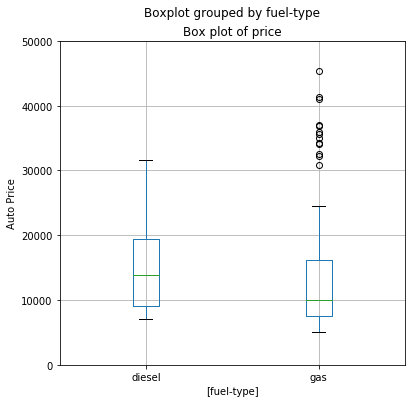

In [61]:
fig = plt.figure(figsize=(6, 6)) # Define plot area
ax = fig.gca() # Define axis 
energy.loc[:,['price', 'fuel-type']].boxplot(by = 'fuel-type', ax = ax)
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('Auto Price')# Set text for y axis
ax.set_ylim(0.0, 50000.0) # Set the limits of the y axis

(0.0, 50000.0)

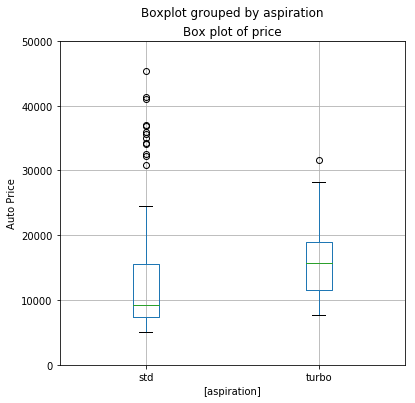

In [60]:
fig = plt.figure(figsize=(6, 6)) # Define plot area
ax = fig.gca() # Define axis 
energy.loc[:,['price', 'aspiration']].boxplot(by = 'aspiration', ax = ax)
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('Auto Price')# Set text for y axis
ax.set_ylim(0.0, 50000.0) # Set the limits of the y axis

(0.0, 50000.0)

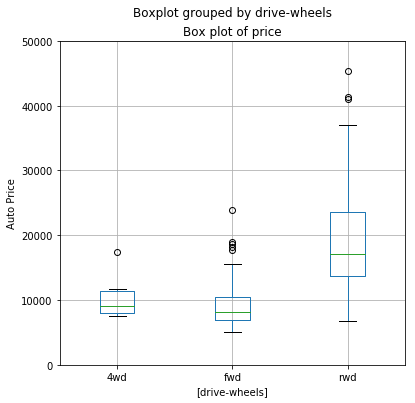

In [52]:
fig = plt.figure(figsize=(6, 6)) # Define plot area
ax = fig.gca() # Define axis 
energy.loc[:,['price', 'drive-wheels']].boxplot(by = 'drive-wheels', ax = ax)
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('Auto Price')# Set text for y axis
ax.set_ylim(0.0, 50000.0) # Set the limits of the y axis

In [5]:
# stratify method adapted from L04-1-Sampling
def stratify(group, dat, p=0.01):
    groups = dat.groupby(group) # Create the groups
    nums = min(groups.size()) # Find the size of the smallest group
    num = int(p * dat.shape[0]) # Compute the desired number of samples per group
    if num <= nums: # If sufficient group size, sample each group and return. 
        return groups.apply(lambda x: x.sample(n=num))
    else: # Oops. p is to large
        pmax = nums / dat.shape[0]
        print('The maximum value of p = ' + str(pmax))
        
# count mean method adapted from L04-1-Sampling
def count_mean(group, dat):
    groups = dat.groupby(group) # Create the groups
    ## Create a data frame with the counts and the means of the groups
    return pd.DataFrame({'count': groups.size(), 
                        'mean': groups.aggregate(np.mean).loc[:, 'price']})
        
# create stratified groups
fuel_strat = stratify('fuel-type', energy)
aspiration_strat = stratify('aspiration', energy)
drive_strat = stratify('drive-wheels', energy)

In [74]:
count_mean('fuel-type', fuel_strat)

/Users/tcrosse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 'fuel-type' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


,count,mean
fuel-type,,
diesel,1,7788
gas,1,7349


In [68]:
count_mean('aspiration', aspiration_strat)

/Users/tcrosse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 'aspiration' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


,count,mean
aspiration,,
std,1,8495
turbo,1,12764


In [71]:
count_mean('drive-wheels', drive_strat)

/Users/tcrosse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 'drive-wheels' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


,count,mean
drive-wheels,,
4wd,1,11259
fwd,1,7799
rwd,1,18150


### 2. Discussion
The graphical and formal test show similar patterns on the influence of the categories on price. Cars with diesel's are slightly more valuable than cars with gas, cars with turbos are more valuable than standard, and cars with rear-wheel drive are more valuable than cars with 4wd, which is more valuable than cars with front wheel drive.

## 3. ANOVA & Turkey HSD testing body style
Apply ANOVA and Tukey's HSD test to the auto price data to compare the price (or log price if closer to a normal distribution) of autos stratified by body style.

In [8]:
energy['body-style'].value_counts()

sedan          94
hatchback      63
wagon          24
hardtop         8
convertible     6
Name: body-style, dtype: int64

In [33]:
sedans = energy.loc[energy.loc[:, 'body-style'] == 'sedan', 'price']
hatchbacks = energy.loc[energy.loc[:, 'body-style'] == 'hatchback', 'price']
wagons = energy.loc[energy.loc[:, 'body-style'] == 'wagon', 'price']
hardtops = energy.loc[energy.loc[:, 'body-style'] == 'hardtop', 'price']
convertibles = energy.loc[energy.loc[:, 'body-style'] == 'convertible', 'price']

In [34]:
F, p = stats.f_oneway(sedans, hatchbacks, wagons, hardtops, convertibles)
print('F =', F, 'p =', p)

F = 9.00494047869107 p = 1.1106545919290286e-06


### 3. Discussion


## 4. Graphically exploring price v. categories
Graphically explore the differences between the price conditioned by the categories of each variable. 
Hint: Make sure you have enough data for each category and drop categories with insufficient data.

(0.0, 50000.0)

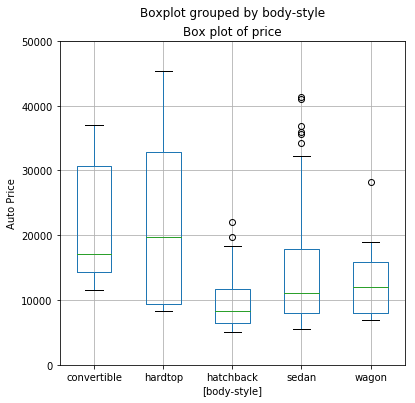

In [35]:
fig = plt.figure(figsize=(6, 6)) # Define plot area
ax = fig.gca() # Define axis 
energy.loc[:,['price', 'body-style']].boxplot(by = 'body-style', ax = ax)
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('Auto Price')# Set text for y axis
ax.set_ylim(0.0, 50000.0) # Set the limits of the y axis

### 4. Discussion


## 5.  ANOVA & Turkey HSD testing categories
Use standard ANOVA and Tukey HSD to test the differences of these groups.

### 5. Discussion